# Napovedovanje časovnih vrst z uporabo regresorja podpornih vektorjev


V tem zvezku bomo prikazali, kako:

- pripraviti 2D časovne vrste podatkov za učenje modela regresorja SVM
- implementirati SVR z uporabo RBF jedra
- oceniti model s pomočjo grafov in MAPE


## Uvažanje modulov


In [1]:
import sys
sys.path.append('../../')

In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape

## Priprava podatkov


### Naloži podatke


In [3]:
energy = load_data('../../data')[['load']]
energy.head(5)

load
2012-01-01 00:00:00  2698.0
2012-01-01 01:00:00  2558.0
2012-01-01 02:00:00  2444.0
2012-01-01 03:00:00  2402.0
2012-01-01 04:00:00  2403.0

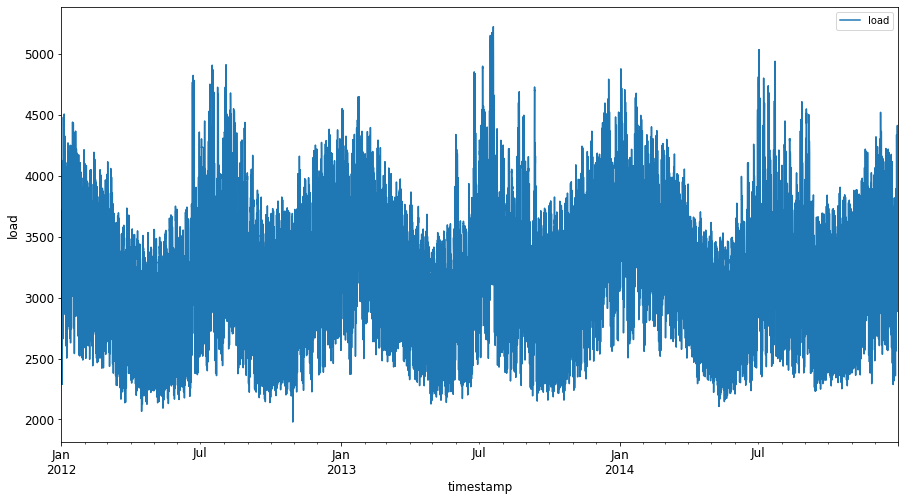

In [4]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [5]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

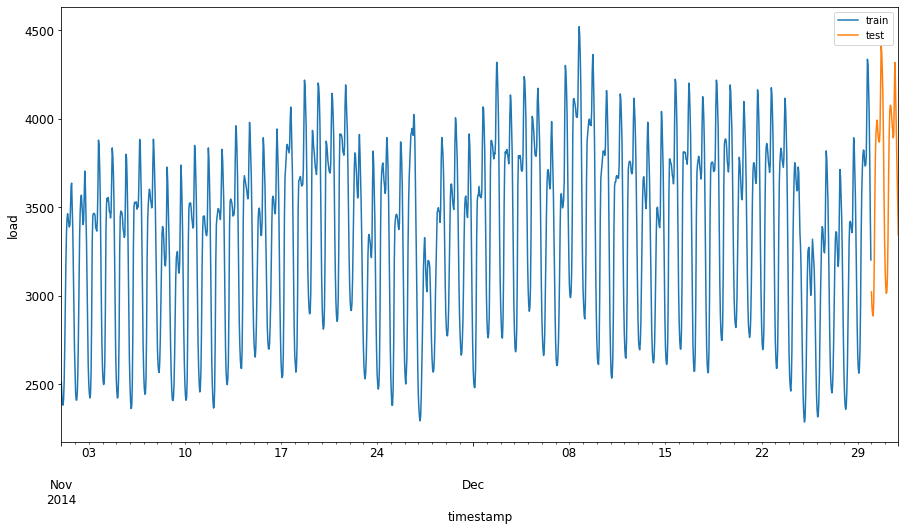

In [6]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Zdaj morate pripraviti podatke za učenje z izvajanjem filtriranja in skaliranja vaših podatkov.


In [7]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


Prilagodite podatke, da bodo v razponu (0, 1).


In [8]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(5)

load
2014-11-01 00:00:00  0.101611
2014-11-01 01:00:00  0.065801
2014-11-01 02:00:00  0.046106
2014-11-01 03:00:00  0.042525
2014-11-01 04:00:00  0.059087

In [9]:
test['load'] = scaler.transform(test)
test.head(5)

load
2014-12-30 00:00:00  0.329454
2014-12-30 01:00:00  0.290063
2014-12-30 02:00:00  0.273948
2014-12-30 03:00:00  0.268129
2014-12-30 04:00:00  0.302596

### Ustvarjanje podatkov s časovnimi koraki


Za naš SVR preoblikujemo vhodne podatke v obliko `[batch, timesteps]`. Tako preoblikujemo obstoječe `train_data` in `test_data`, da dodamo novo dimenzijo, ki se nanaša na časovne korake. V našem primeru vzamemo `timesteps = 5`. Tako so vhodi v model podatki za prve 4 časovne korake, izhod pa bodo podatki za 5. časovni korak.


In [10]:
# Converting to numpy arrays

train_data = train.values
test_data = test.values

In [11]:
# Selecting the timesteps

timesteps=5

In [12]:
# Converting data to 2D tensor

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1412, 5)

In [13]:
# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(44, 5)

In [14]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1412, 4) (1412, 1)
(44, 4) (44, 1)


## Ustvarjanje SVR modela


In [15]:
# Create model using RBF kernel

model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [16]:
# Fit model on training data

model.fit(x_train, y_train[:,0])

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Naredi napoved modela


In [17]:
# Making predictions

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1412, 1) (44, 1)


## Analiza učinkovitosti modela


In [18]:
# Scaling the predictions

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1412 44


In [19]:
# Scaling the original values

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1412 44


In [20]:
# Extract the timesteps for x-axis

train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1412 44


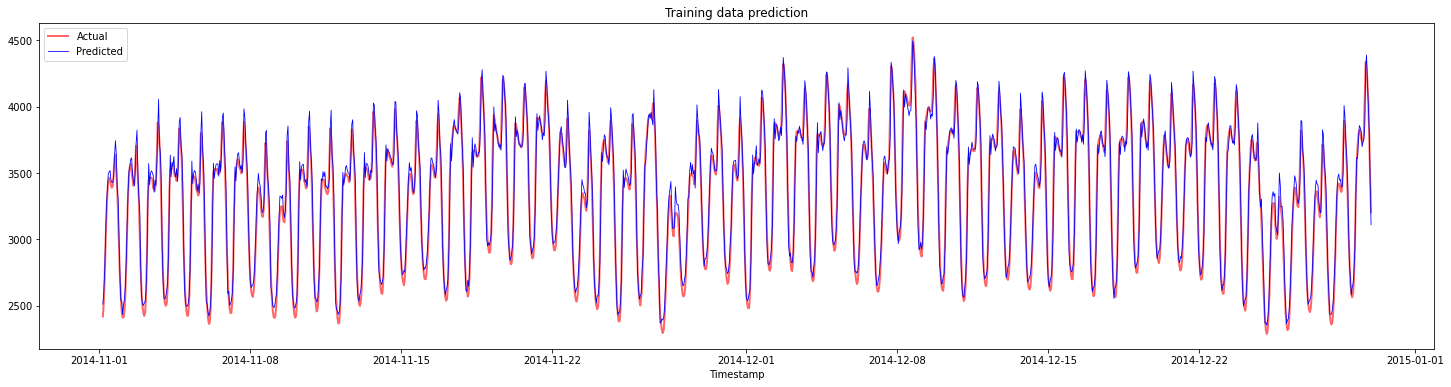

In [21]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [22]:
print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

MAPE for training data:  1.7195710200875551 %


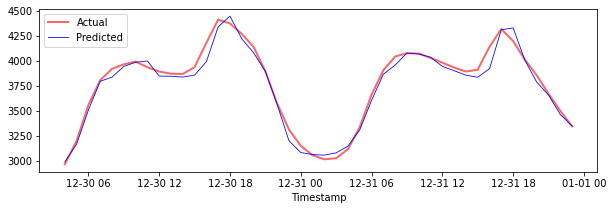

In [23]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [24]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

MAPE for testing data:  1.2623790187854018 %


## Napoved celotnega nabora podatkov


In [25]:
# Extracting load values as numpy array
data = energy.copy().values

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (26300, 5)
X shape:  (26300, 4) 
Y shape:  (26300, 1)


In [26]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

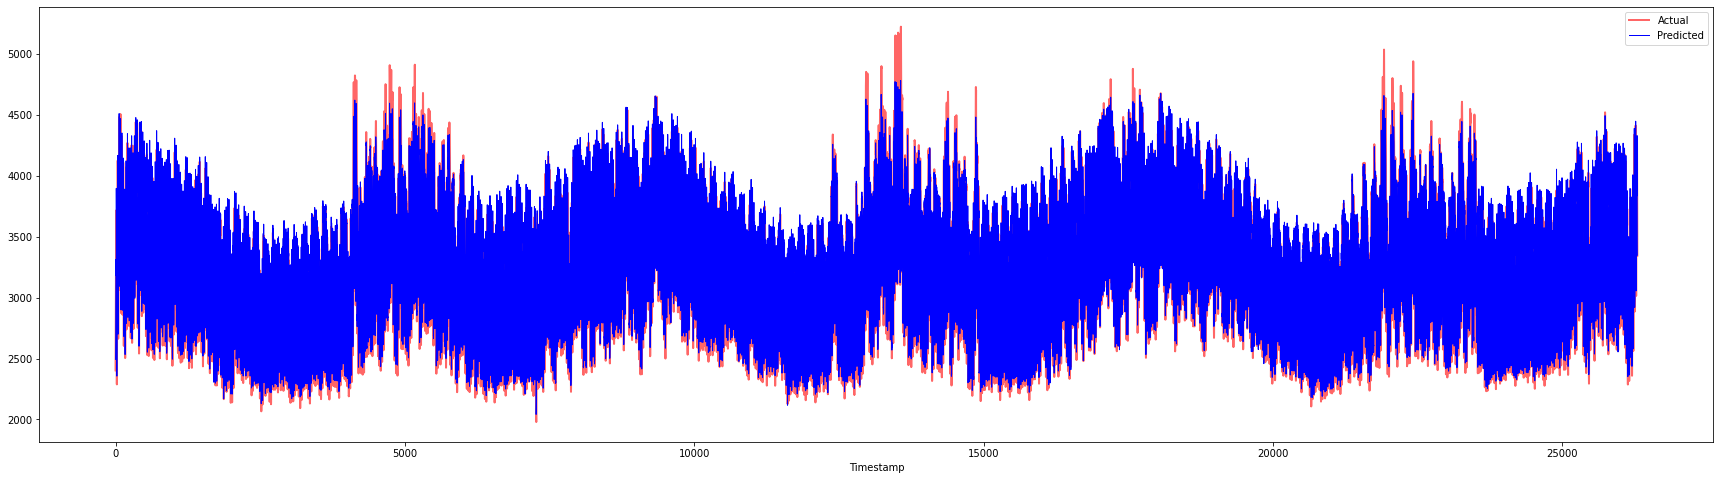

In [27]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=1)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [28]:
print('MAPE: ', mape(Y_pred, Y)*100, '%')

MAPE:  2.0572089029888656 %



---

**Omejitev odgovornosti**:  
Ta dokument je bil preveden z uporabo storitve za strojno prevajanje [Co-op Translator](https://github.com/Azure/co-op-translator). Čeprav si prizadevamo za natančnost, vas prosimo, da upoštevate, da lahko avtomatizirani prevodi vsebujejo napake ali netočnosti. Izvirni dokument v njegovem izvirnem jeziku je treba obravnavati kot avtoritativni vir. Za ključne informacije priporočamo strokovno človeško prevajanje. Ne prevzemamo odgovornosti za morebitna nesporazumevanja ali napačne razlage, ki izhajajo iz uporabe tega prevoda.
